# Imports:

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Constants:

In [2]:
PROB_FILE = 'SpamData/03_Testing/token-prob.csv'
TEST_TARGET_FILE = 'SpamData/03_Testing/test-target.txt'
TEST_FEATURE_MATRIX = 'SpamData/03_Testing/test-feature.txt'

VOCAB_SIZE = 2501
spam_email_prob = 0.3261086198305929

SPAM_CAT = 0
HAM_CAT = 1

# Load Data:

In [3]:
y_target = np.loadtxt(TEST_TARGET_FILE, delimiter=' ')
X_target = np.loadtxt(TEST_FEATURE_MATRIX, delimiter=' ')

In [4]:
prob = pd.read_csv(PROB_FILE)
prob.head()

,WORD_ID,IN_SPAM,IN_HAM,OVERALL,PROB_SPAM,PROB_HAM,PROB_OVERALL
0,0,1631,4622,6253,0.009432,0.021443,0.016209
1,1,1054,1830,2884,0.006095,0.008490,0.007476
2,2,1795,850,2645,0.010381,0.003943,0.006857
3,3,1073,1564,2637,0.006205,0.007256,0.006836
4,4,1218,1222,2440,0.007044,0.005669,0.006325


In [5]:
prob.PROB_SPAM.shape

(2501,)

In [6]:
X_target.shape

(1721, 2501)

# Set Prior:

## $$P(Spam \,| \,X) = \frac{P(\,X \,| \, Spam \,) \, P(\,Spam\,)}{P(X)}$$

In [7]:
prob_token_spam = np.array(prob.PROB_SPAM)

In [8]:
joint_log_spam = X_target.dot(np.log(prob.PROB_SPAM) - np.log(prob.PROB_OVERALL)) + np.log(spam_email_prob)

## $$P(Ham \,| \,X) = \frac{P(\,X \,| \, Ham \,) \,(1 - P(\,Spam\,))}{P(X)}$$

In [9]:
joint_log_ham = X_target.dot(np.log(prob.PROB_HAM) - np.log(prob.PROB_OVERALL)) + np.log(1 - spam_email_prob)

# Making Predictions :

### Checking for higher joint probability

$$P(Spam\,|\,X) > P(Ham\,|\,X)$$
<center><b> OR </b></center>
$$P(Spam\,|\,X) < P(Ham\,|\,X)$$

In [10]:
prediction = (joint_log_ham > joint_log_spam) * 1

In [11]:
prediction 

array([1, 1, 0, ..., 0, 0, 0])

In [12]:
y_target

array([1., 1., 1., ..., 0., 0., 0.])

## Simplify

In [13]:
joint_log_spam = X_target.dot(np.log(prob.PROB_SPAM)) + np.log(spam_email_prob)
joint_log_ham = X_target.dot(np.log(prob.PROB_HAM)) + np.log(1 - spam_email_prob)

## Metrics and Evaluation :
### Accuracy :

In [14]:
correct_docs = (y_target == prediction).sum()
wrong_docs = y_target.shape[0] - correct_docs
print(f'Nbr. of Correct Docs : {correct_docs}')
print(f'Nbr. of Wrong Docs : {wrong_docs}')

Nbr. of Correct Docs : 1695
Nbr. of Wrong Docs : 26


In [15]:
accuracy = round(correct_docs /  y_target.shape[0] ,2)
print('The Accuracy rate is : {:.2%}'.format(accuracy))

The Accuracy rate is : 98.00%


## Visualizing Results:

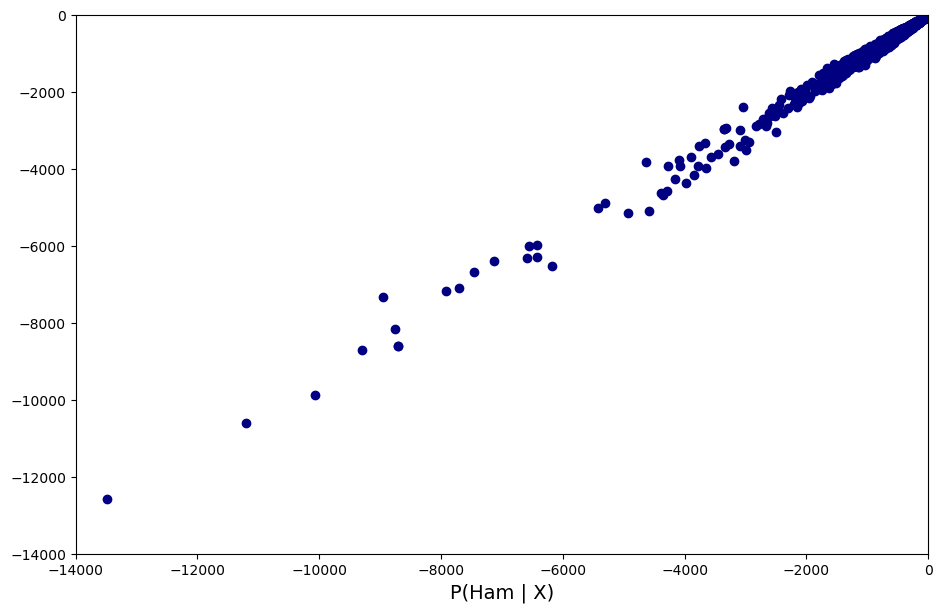

In [16]:
plt.figure(figsize=(11,7))
plt.xlabel('P(Spam | X)' ,fontsize=14)
plt.xlabel('P(Ham | X)' ,fontsize=14)

plt.xlim([-14000, 1])
plt.ylim([-14000, 1])

plt.scatter(joint_log_ham, joint_log_spam, color='navy')
plt.show()

## Decision Boundary:

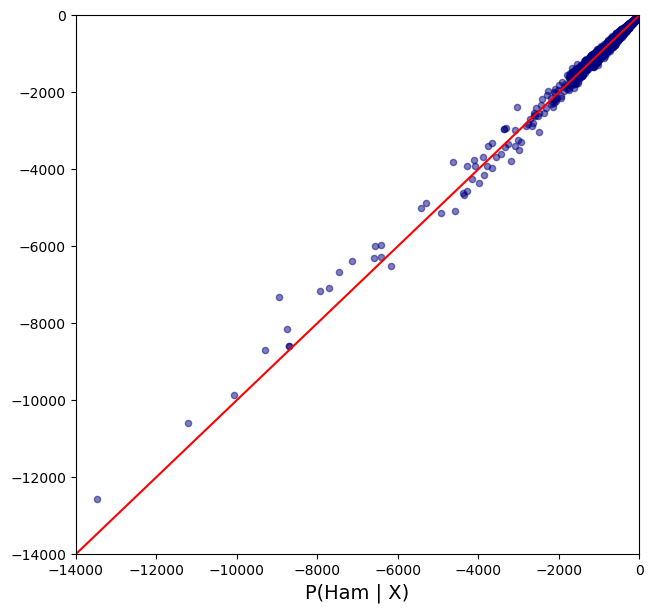

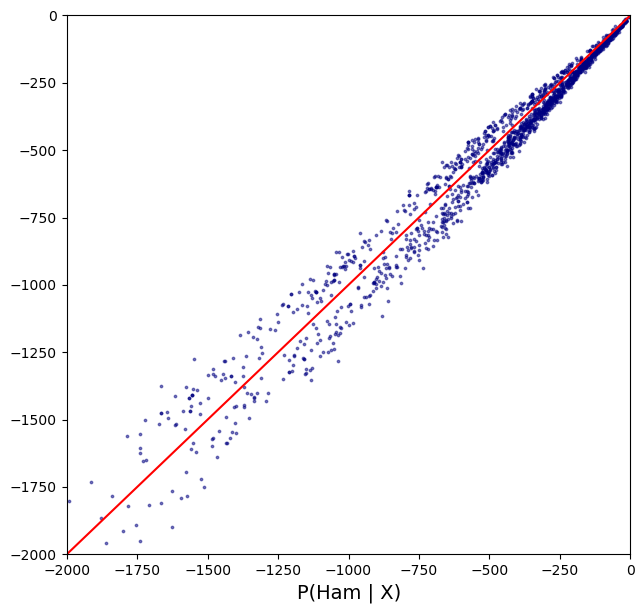

In [17]:
xaxis_label = 'P(Spam | X)'
yaxis_label = 'P(Ham | X)'
linedata = np.linspace(-2000,1,1000)

plt.figure(figsize=(16,7))

# 1st Plot
plt.subplot(1,2,1)

plt.xlabel(xaxis_label ,fontsize=14)
plt.xlabel(yaxis_label ,fontsize=14)

plt.xlim([-14000, 1])
plt.ylim([-14000, 1])

plt.scatter(joint_log_ham, joint_log_spam, color='navy', alpha=0.5, s=20)
plt.plot(np.linspace(-14000,1,1000), np.linspace(-14000,1,1000), color='red')
plt.show()

# 2nd Plot
plt.figure(figsize=(16,7))

plt.subplot(1,2,2)

plt.xlabel('P(Spam | X)' ,fontsize=14)
plt.xlabel('P(Ham | X)' ,fontsize=14)

plt.xlim([-2000, 1])
plt.ylim([-2000, 1])

plt.scatter(joint_log_ham, joint_log_spam, color='navy', alpha=0.5, s=3)
plt.plot(linedata, linedata, color='red')
plt.show()

In [18]:
sns.set_style('whitegrid')
labels = 'Actual Category'
my_palette = ['#AB3A2C', '#314290']

summary_df = pd.DataFrame({xaxis_label: joint_log_spam, 
                           yaxis_label: joint_log_ham, 
                           labels : y_target})

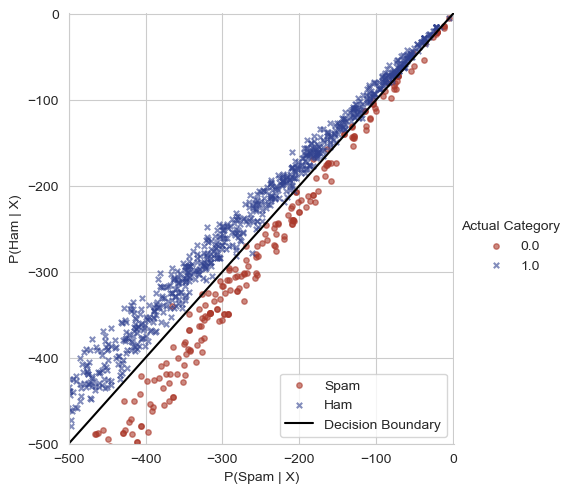

In [19]:
sns.lmplot(x=xaxis_label,
           y=yaxis_label, 
           data=summary_df, 
           scatter_kws={'alpha':0.6, 's':15}, 
           fit_reg=False,
           hue=labels,
           markers=['o', 'x'],
           palette=my_palette)

plt.xlim([-500, 1])
plt.ylim([-500, 1])

plt.plot(linedata, linedata, color='black')
plt.legend(('Spam', 'Ham', 'Decision Boundary'), loc='lower right', fontsize=10)
plt.show()

## False Positive and False Negatives

In [20]:
np.unique(prediction, return_counts=True)

(array([0, 1]), array([ 517, 1204], dtype=int64))

In [21]:
true_pos = ((prediction == 0) & (y_target == 0)).sum()

In [22]:
false_pos = np.unique(prediction, return_counts=True)[1][0] - true_pos
false_pos

8

In [23]:
true_neg =((prediction == 1) & (y_target == 1)).sum()
true_neg

1186

In [24]:
false_neg = np.unique(prediction, return_counts=True)[1][1] - true_neg
false_neg

18

## Recall Score

In [25]:
recall_score = true_pos / (true_pos + false_neg)
print('Recall Score is {:.2%}'.format(recall_score))

Recall Score is 96.58%


## Precision Score

In [26]:
precision_score = true_pos / (true_pos + false_pos)
print('Precision Score is {:.2%}'.format(precision_score))

Precision Score is 98.45%


## F-Score or F1-Score

In [27]:
f1_score = 2 * precision_score * recall_score / (precision_score + recall_score)
print('F1-Score is {:.2%}'.format(f1_score))

F1-Score is 97.51%
